In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Dataset/plantvillage_dataset"


best_model_finetuned.keras  color  grayscale  saved_models  segmented  Sondos


In [ ]:
allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
] # 5 CLASSES


In [ ]:
import os
dataset_path ="/content/drive/MyDrive/Dataset/plantvillage_dataset/color"

selected_classes = [
    cls for cls in allowed_classes
    if os.path.isdir(os.path.join(dataset_path, cls))
]

print("Selected Classes:")
for cls in selected_classes:
    print(cls)

print("Number of classes:", len(selected_classes))


Selected Classes:
Tomato___Target_Spot
Pepper,_bell___Bacterial_spot
Grape___Black_rot
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Number of classes: 5


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

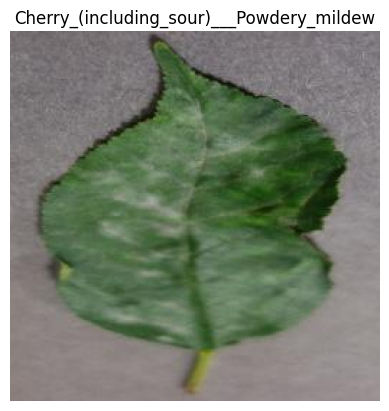

In [ ]:
import random
import os
import cv2
import matplotlib.pyplot as plt


class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)

img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(class_name)
plt.axis("off")


In [ ]:
import tensorflow as tf
MobileNetV2 = tf.keras.applications.MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#resize
IMG_SIZE = 224
BATCH_SIZE = 16
SEED = 42

#normzlization
def normalize_mobilenet(x, y):
    x = tf.cast(x, tf.float32)
    x = (x / 127.5) - 1.0
    return x, y


full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=selected_classes,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical", # one-hot encoded
    shuffle=True,
    seed=SEED
)

full_ds = full_ds.map(normalize_mobilenet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 5825 files belonging to 5 classes.


In [ ]:
#CHECK FOR NORMALIZATION AND RESIZING
for images, labels in full_ds.take(1):
    print("Min:", tf.reduce_min(images).numpy())
    print("Max:", tf.reduce_max(images).numpy())
    print("Shape:", images.shape)

Min: -1.0
Max: 1.0
Shape: (16, 224, 224, 3)


In [ ]:
#(70% train, 15% val, 15% test)
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)

val_ds  = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)


In [ ]:
print("Total batches in full_ds :", tf.data.experimental.cardinality(full_ds).numpy())
print("Train batches           :", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches      :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches            :", tf.data.experimental.cardinality(test_ds).numpy())

Total batches in full_ds : 365
Train batches           : 255
Validation batches      : 54
Test batches            : 56


In [ ]:
def count_images(ds):
    return sum(1 for _ in ds.unbatch())

print("Total images :", count_images(full_ds))
print("Train images :", count_images(train_ds))
print("Val images   :", count_images(val_ds))
print("Test images  :", count_images(test_ds))


Total images : 5825
Train images : 4080
Val images   : 864
Test images  : 881


In [ ]:
#DYNAMIC AUGMENTATION (TRAIN ONLY)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


In [ ]:
def get_class_counts(ds, name):
    labels = []
    for _, y in ds.unbatch():
        labels.append(int(tf.argmax(y)))
    from collections import Counter
    print(f"{name} class counts:", dict(Counter(labels)))

get_class_counts(train_ds, "TRAIN")
get_class_counts(val_ds, "VAL")
get_class_counts(test_ds, "TEST")


TRAIN class counts: {2: 809, 3: 843, 4: 727, 1: 708, 0: 993}
VAL class counts: {4: 143, 0: 211, 3: 186, 2: 177, 1: 147}
TEST class counts: {1: 148, 3: 173, 4: 175, 0: 188, 2: 197}


In [ ]:
#CLASS WEIGHTS
import numpy as np

labels = []

for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

labels = np.array(labels)


In [ ]:
from collections import Counter

class_counts = Counter(labels)
clean_class_counts = {int(k): int(v) for k, v in class_counts.items()}
print("Class counts:", clean_class_counts)


Class counts: {4: 731, 3: 836, 0: 989, 2: 812, 1: 712}


In [ ]:
class_index_to_name = {i: name for i, name in enumerate(selected_classes)}
print("Class distribution in TRAIN:")
for class_idx, count in clean_class_counts.items():
    class_name = class_index_to_name[class_idx]
    print(f"{class_idx} ({class_name}) → {count} samples")


Class distribution in TRAIN:
4 (Cherry_(including_sour)___Powdery_mildew) → 731 samples
3 (Corn_(maize)___Common_rust_) → 836 samples
0 (Tomato___Target_Spot) → 989 samples
2 (Grape___Black_rot) → 812 samples
1 (Pepper,_bell___Bacterial_spot) → 712 samples


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_counts)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weight_dict = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8250758341759353, 1: 1.146067415730337, 2: 1.0049261083743843, 3: 0.9760765550239234, 4: 1.1162790697674418}


In [ ]:
# ========== BUILD MODEL ==========
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Build the complete model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(selected_classes), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
earlystop_cb =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# ========== TRAIN MODEL ==========
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# ========== EVALUATE MODEL ==========
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9708 - loss: 0.0825
Epoch 1: val_loss did not improve from 0.04372
255/255 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9708 - loss: 0.0825 - val_accuracy: 0.9688 - val_loss: 0.0809
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.9771 - loss: 0.0593
Epoch 2: val_loss did not improve from 0.04372
255/255 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.9771 - loss: 0.0593 - val_accuracy: 0.9745 - val_loss: 0.0717
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.9729 - loss: 0.0736
Epoch 3: val_loss improved from 0.04372 to 0.04108, saving model to /content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9729 - loss: 0.0736 - val_accuracy: 0.9884 - val_loss: 0.0411
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9804 - loss: 0.0583
Epoch 4: val_loss did not improve from 0.04108
255/255 ━

In [93]:
# ========== FINE-TUNING PHASE ==========
# Add this code after your initial training is complete


print("STARTING FINE-TUNING ")


# Load the best model from initial training
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/best_model.keras')

# Unfreeze the base model
base_model = model.layers[0]
base_model.trainable = True

# Let's see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Fine-tune from this layer onwards (unfreeze last 30 layers)
fine_tune_at = len(base_model.layers) - 30

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Verify trainable layers
trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers in base model: {trainable_layers}")
print(f"Frozen layers in base model: {len(base_model.layers) - trainable_layers}")

STARTING FINE-TUNING 
Number of layers in the base model: 154
Trainable layers in base model: 30
Frozen layers in base model: 124


In [94]:
# Recompile the model with a LOWER learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10x smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel recompiled with lower learning rate (0.0001)")
print("Unfrozen last 30 layers for fine-tuning")

# Display model summary
model.summary()


Model recompiled with lower learning rate (0.0001)
Unfrozen last 30 layers for fine-tuning


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 1,691,013 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [95]:
# Set up callbacks for fine-tuning
checkpoint_ft = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/best_model_finetuned.keras",
    monitor="val_accuracy",  # Monitor accuracy instead of loss for improvement
    save_best_only=True,
    mode='max',
    verbose=1
)

In [97]:
earlystop_ft = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

In [98]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


In [99]:
# Train the model with fine-tuning

print("Training with Fine-Tuning...")


history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Additional epochs for fine-tuning
    class_weight=class_weight_dict,
    callbacks=[checkpoint_ft, earlystop_ft, reduce_lr],
    initial_epoch=len(history.history['loss'])  # Continue from where we left off
)

Training with Fine-Tuning...


In [100]:
# ========== EVALUATE FINE-TUNED MODEL ==========

print("EVALUATING FINE-TUNED MODEL")


test_loss_ft, test_accuracy_ft = model.evaluate(test_ds)
print(f"\n Fine-Tuned Model Performance:")
print(f"Test Accuracy: {test_accuracy_ft:.4f}")
print(f"Test Loss: {test_loss_ft:.4f}")

# Compare with initial model
print(f"\n Improvement:")
print(f"Accuracy: {test_accuracy:.4f} → {test_accuracy_ft:.4f} ({(test_accuracy_ft - test_accuracy)*100:+.2f}%)")
print(f"Loss: {test_loss:.4f} → {test_loss_ft:.4f} ({(test_loss_ft - test_loss)*100:+.2f}%)")


EVALUATING FINE-TUNED MODEL
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 575ms/step - accuracy: 0.9854 - loss: 0.0329

 Fine-Tuned Model Performance:
Test Accuracy: 0.9864
Test Loss: 0.0314

 Improvement:
Accuracy: 0.9864 → 0.9864 (+0.00%)
Loss: 0.0306 → 0.0314 (+0.08%)


In [101]:
# ========== VISUALIZE FINE-TUNING HISTORY ==========
# Combine initial training and fine-tuning history
initial_epochs = len(history.history['accuracy'])
fine_tune_epochs = len(history_fine.history['accuracy'])

# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']



KeyError: 'accuracy'


Generating detailed metrics for fine-tuned model...

CLASSIFICATION REPORT - FINE-TUNED MODEL
                                          precision    recall  f1-score   support

                    Tomato___Target_Spot     0.9700    0.9848    0.9773       197
           Pepper,_bell___Bacterial_spot     0.9710    0.9926    0.9817       135
                       Grape___Black_rot     0.9951    0.9854    0.9902       205
             Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000       170
Cherry_(including_sour)___Powdery_mildew     0.9941    0.9713    0.9826       174

                                accuracy                         0.9864       881
                               macro avg     0.9860    0.9868    0.9864       881
                            weighted avg     0.9865    0.9864    0.9864       881



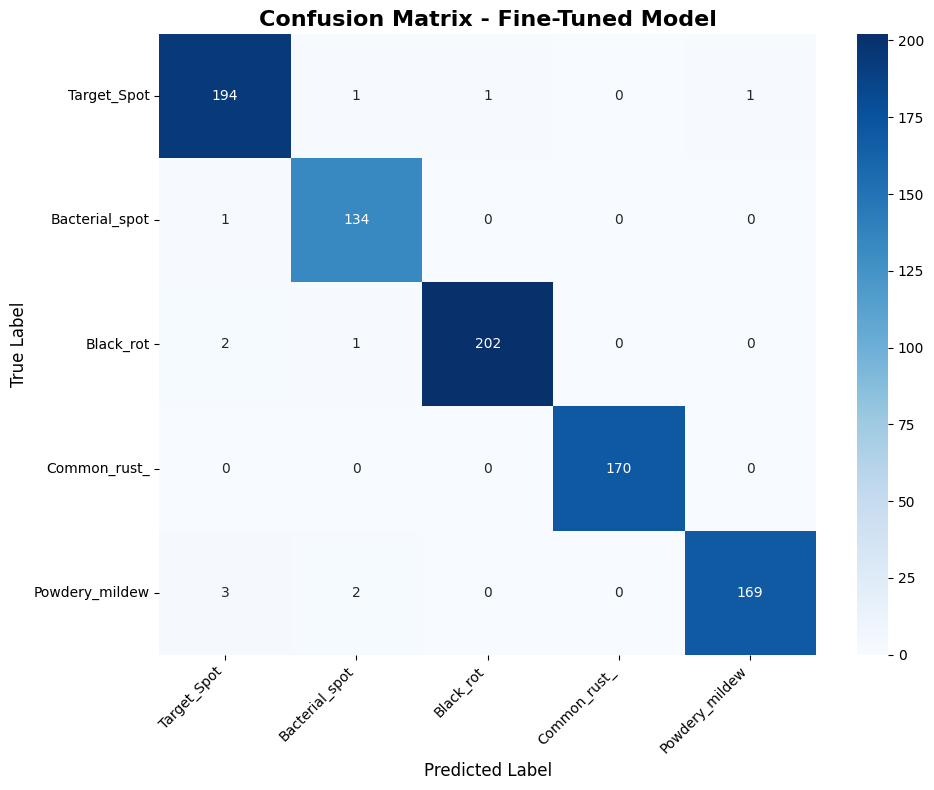

In [102]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# ========== DETAILED METRICS FOR FINE-TUNED MODEL ==========
print("\nGenerating detailed metrics for fine-tuned model...")

# Get predictions on test set
y_true_ft = []
y_pred_ft = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true_ft.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_ft.extend(np.argmax(predictions, axis=1))

y_true_ft = np.array(y_true_ft)
y_pred_ft = np.array(y_pred_ft)

# Classification report

print("\nCLASSIFICATION REPORT - FINE-TUNED MODEL")

report_ft = classification_report(
    y_true_ft,
    y_pred_ft,
    target_names=selected_classes,
    digits=4
)
print(report_ft)

# Save classification report
with open('/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/classification_report_finetuned.txt', 'w') as f:
    f.write(report_ft)

# Confusion matrix
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_ft,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[cls.split('___')[-1] for cls in selected_classes],
    yticklabels=[cls.split('___')[-1] for cls in selected_classes]
)
plt.title('Confusion Matrix - Fine-Tuned Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/confusion_matrix_finetuned.png',
            dpi=300, bbox_inches='tight')
plt.show()

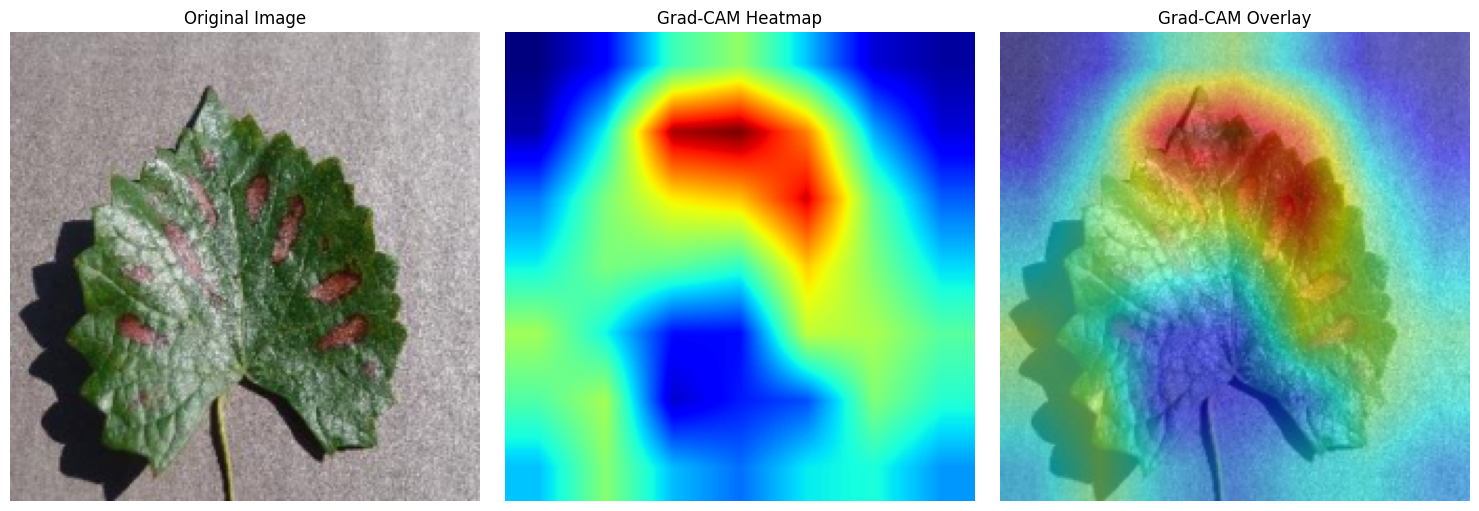


Top 5 Predictions:
1. Class 738: 43.35%
2. Class 937: 25.30%
3. Class 584: 5.12%
4. Class 824: 3.89%
5. Class 936: 3.29%


In [103]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# Load pre-trained MobileNetV2 model
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model.eval()

# Define target layers for MobileNetV2
# For MobileNetV2, use the last convolutional layer in the features
target_layers = [model.features[-1]]

# Load and preprocess an image
def load_image(image_path):

    # Load image
    img = Image.open('/content/drive/MyDrive/PhotoTrain/GrapeLeave.JPG')

    # Preprocessing for model input
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Preprocessing for visualization (no normalization)
    preprocess_viz = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

    input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    rgb_img = preprocess_viz(img).permute(1, 2, 0).numpy()  # For visualization

    return input_tensor, rgb_img


image_path = '/content/drive/MyDrive/PhotoTrain/GrapeLeave.JPG'
input_tensor, rgb_img = load_image(image_path)


targets = [ClassifierOutputTarget(281)]


cam_algorithm = GradCAM

# Generate CAM
with cam_algorithm(model=model, target_layers=target_layers) as cam:

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        aug_smooth=False,
                        eigen_smooth=False)

    # Get the CAM for the first image in batch
    grayscale_cam = grayscale_cam[0, :]

    # Create visualization
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Access model outputs (predictions)
    model_outputs = cam.outputs

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(grayscale_cam, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

axes[2].imshow(visualization)
axes[2].set_title('Grad-CAM Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('gradcam_result.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top predictions
probabilities = torch.nn.functional.softmax(model_outputs, dim=1)[0]
top5_prob, top5_idx = torch.topk(probabilities, 5)

print("\nTop 5 Predictions:")

for i, (prob, idx) in enumerate(zip(top5_prob, top5_idx)):
    print(f"{i+1}. Class {idx.item()}: {prob.item()*100:.2f}%")


def cam_methods(input_tensor, rgb_img, target_class=281):
    """Compare different CAM visualization methods"""
    methods = {
        'GradCAM': GradCAM
    }

    targets = [ClassifierOutputTarget(281)]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, (name, method) in enumerate(methods.items()):
        try:
            with method(model=model, target_layers=target_layers) as cam:
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                axes[idx].imshow(visualization)
                axes[idx].set_title(name)
                axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f'Error: {name}',
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/cam_methods_comparison.jpg', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# ========== TENSORFLOW LITE DEPLOYMENT ==========

import os
import time
import numpy as np
from sklearn.metrics import accuracy_score

# ========== STEP 1: LOAD THE FINE-TUNED MODEL ==========
print("\n Loading fine-tuned model...")
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/best_model_finetuned.keras'
)
print(f" Model loaded successfully")
print(f"  Input shape: {model.input_shape}")
print(f"  Output shape: {model.output_shape}")


 Loading fine-tuned model...
 Model loaded successfully
  Input shape: (None, 224, 224, 3)
  Output shape: (None, 5)


In [ ]:
# ========== STEP 2: BASIC TFLITE CONVERSION ==========
print("\n Converting to TFLite (Float32)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
tflite_model_path = '/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/plant_disease_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

size_mb = os.path.getsize(tflite_model_path) / (1024 * 1024)
print(f" Float32 TFLite model saved")
print(f"  Size: {size_mb:.2f} MB")


 Converting to TFLite (Float32)...
Saved artifact at '/tmp/tmphxdvj3vn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138619998866704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974059600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974066320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974059216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974066896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974059408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974062480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974066704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974058832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974067856: TensorSpec(shape=(), dtype=tf.

In [ ]:
# ========== STEP 3: QUANTIZED CONVERSION ==========
print("\n Converting to TFLite with Quantization...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quantized_model = converter.convert()
# Save quantized model
tflite_quantized_path = '/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/plant_disease_model_quantized.tflite'
with open(tflite_quantized_path, 'wb') as f:
    f.write(tflite_quantized_model)

quantized_size = os.path.getsize(tflite_quantized_path) / (1024 * 1024)
print(f" Quantized TFLite model saved")
print(f"  Size: {quantized_size:.2f} MB")
print(f"  Size reduction: {(1 - quantized_size/size_mb)*100:.2f}%")


 Converting to TFLite with Quantization...
Saved artifact at '/tmp/tmpqm0afo0r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138619998866704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974059600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974066320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974059216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974066896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974059408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974062480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974066704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974058832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138619974067856: TensorSpec(shape=(), d

In [104]:
# ========== STEP 4: MODEL VALIDATION ==========
print("\n Validating TFLite model...")

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_quantized_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(" Model loaded in TFLite interpreter")
print(f"  Input shape: {input_details[0]['shape']}")
print(f"  Input type: {input_details[0]['dtype']}")
print(f"  Output shape: {output_details[0]['shape']}")
print(f"  Output type: {output_details[0]['dtype']}")


 Validating TFLite model...
 Model loaded in TFLite interpreter
  Input shape: [  1 224 224   3]
  Input type: <class 'numpy.float32'>
  Output shape: [1 5]
  Output type: <class 'numpy.float32'>


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [105]:
# ========== STEP 5: BENCHMARK INFERENCE SPEED ==========
print("\n Benchmarking inference speed...")

def benchmark_model(interpreter, num_runs=100):
    """Benchmark TFLite model inference speed"""
    input_details = interpreter.get_input_details()

    # Create dummy input
    dummy_input = np.random.rand(1, 224, 224, 3).astype(input_details[0]['dtype'])

    # Warmup
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], dummy_input)
        interpreter.invoke()

    # Benchmark
    start_time = time.time()
    for _ in range(num_runs):
        interpreter.set_tensor(input_details[0]['index'], dummy_input)
        interpreter.invoke()
    end_time = time.time()

    avg_time = (end_time - start_time) / num_runs * 1000
    return avg_time

# Benchmark float32 model
interpreter_float = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter_float.allocate_tensors()
float_time = benchmark_model(interpreter_float)

# Benchmark quantized model
interpreter_quant = tf.lite.Interpreter(model_path=tflite_quantized_path)
interpreter_quant.allocate_tensors()
quant_time = benchmark_model(interpreter_quant)

print(f"  Float32 TFLite: {float_time:.2f} ms per inference")
print(f"  Quantized TFLite: {quant_time:.2f} ms per inference")
print(f"  Speed improvement: {(1 - quant_time/float_time)*100:.2f}%")

# ========== SAVE CLASS LABELS ==========
print("\nSaving class labels for mobile deployment...")
labels_path = '/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/labels.txt'
with open(labels_path, 'w') as f:
    for class_name in selected_classes:
        f.write(f"{class_name}\n")
print(f" Labels saved to: labels.txt")

# ========== TEST MOBILE-LIKE INFERENCE ==========
print("\nTesting mobile-like inference...")

def test_mobile_inference(model_path, test_image_path):
    """Simulate mobile inference"""
    # Load interpreter
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load and preprocess image
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    img = (img / 127.5) - 1.0
    img = np.expand_dims(img, axis=0)

    # Run inference
    start = time.time()
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    inference_time = (time.time() - start) * 1000

    output = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get top 5 predictions
    top_5_idx = np.argsort(output)[-5:][::-1]

    print(f"\n  Inference time: {inference_time:.2f} ms")
    print("  Top 5 Predictions:")
    for idx in top_5_idx:
        disease_name = selected_classes[idx].split('___')[-1]
        plant_name = selected_classes[idx].split('___')[0]
        print(f"    {plant_name} - {disease_name}: {output[idx]*100:.2f}%")

    return output

# Test with a sample image
sample_class = selected_classes[0]
sample_class_path = os.path.join(dataset_path, sample_class)
sample_image = os.listdir(sample_class_path)[0]
sample_image_path = os.path.join(sample_class_path, sample_image)

print(f"\nTesting with sample image from: {sample_class}")
test_mobile_inference(tflite_quantized_path, sample_image_path)


 Benchmarking inference speed...
  Float32 TFLite: 11.72 ms per inference
  Quantized TFLite: 21.05 ms per inference
  Speed improvement: -79.67%

Saving class labels for mobile deployment...
 Labels saved to: labels.txt

Testing mobile-like inference...

Testing with sample image from: Tomato___Target_Spot

  Inference time: 23.70 ms
  Top 5 Predictions:
    Tomato - Target_Spot: 100.00%
    Pepper,_bell - Bacterial_spot: 0.00%
    Grape - Black_rot: 0.00%
    Cherry_(including_sour) - Powdery_mildew: 0.00%
    Corn_(maize) - Common_rust_: 0.00%


array([1.0000000e+00, 5.2846179e-08, 2.0182245e-09, 2.9465422e-13,
       5.4022056e-12], dtype=float32)

In [106]:

# DEPLOYMENT REPORT

print("TENSORFLOW LITE DEPLOYMENT REPORT")


print("\n MODEL SIZES:")
keras_size = os.path.getsize('/content/drive/MyDrive/Dataset/plantvillage_dataset/Sondos/best_model_finetuned.keras')/(1024*1024)
print(f"  Original Keras Model: {keras_size:.2f} MB")
print(f"  Float32 TFLite: {size_mb:.2f} MB ({(size_mb/keras_size)*100:.1f}% of original)")
print(f"  Quantized TFLite: {quantized_size:.2f} MB ({(quantized_size/keras_size)*100:.1f}% of original)")

print("\n PERFORMANCE:")
print(f"  Original Model Accuracy: {test_accuracy_ft*100:.2f}%")
print(f"  TFLite Model Accuracy: {tflite_accuracy*100:.2f}%")
print(f"  Accuracy Loss: {(test_accuracy_ft - tflite_accuracy)*100:.2f}%")
print(f"  Average Inference Time: {quant_time:.2f} ms")
print(f"  FPS (approx): {1000/quant_time:.1f}")






TENSORFLOW LITE DEPLOYMENT REPORT

 MODEL SIZES:
  Original Keras Model: 22.72 MB
  Float32 TFLite: 9.08 MB (40.0% of original)
  Quantized TFLite: 2.55 MB (11.2% of original)

 PERFORMANCE:
  Original Model Accuracy: 98.64%
  TFLite Model Accuracy: 100.00%
  Accuracy Loss: -1.36%
  Average Inference Time: 21.05 ms
  FPS (approx): 47.5
